In [1]:
# AETZ model replication using pytorch

import torch
from torch import nn
import numpy as np

# get CUDA index
DEVICE = torch.cuda.current_device()

In [2]:
import matplotlib.pyplot as plt
from itertools import combinations


plt.rcParams["figure.figsize"] = (15,5)


In [3]:
# network class
class aet_net(nn.Module):
    
    # create A,E,T,Z stimuli
    def mkstim(noise_=False):
        # create stimuli
        A = torch.zeros((28,28))
        A[8:23,6:9] = 1
        A[5:8,8:19] = 1
        A[16:19,8:19] = 1
        A[8:23,19:22] = 1


        E = torch.zeros((28,28))
        E[4:23,6:9] = 1
        E[4:7,8:21] = 1
        E[12:15,8:21] = 1
        E[20:23,8:21] = 1

        T = torch.zeros((28,28))
        T[6:10,6:22] = 1
        T[8:23,12:16] = 1

        Z = torch.zeros((28,28))
        Z[6:8, 6:22] = 1
        Z[21:23, 6:22] = 1

        ru = 8
        cu = torch.arange(18,22)
        rl = 20

        for i in torch.arange(13):
            Z[ru,cu] = 1
            ru +=1
            cu -=1
            rl -=1


        # 2. Place letters in larger image
        BIGA = torch.zeros((4,56,56))
        BIGE = torch.zeros((4,56,56))
        BIGT = torch.zeros((4,56,56))
        BIGZ = torch.zeros((4,56,56))

        s =  torch.arange(0,56).reshape((2,-1))     # split in half

        q = 0                # quadrant counter

        # loop over height
        for h in range(int(BIGA.shape[0]/2)):
            # looper over width
            for w in range((int(BIGA.shape[0]/2))):

                BIGA[q,s[h,0]:s[h,-1]+1,s[w,0]:s[w,-1]+1] += A
                BIGE[q,s[h,0]:s[h,-1]+1,s[w,0]:s[w,-1]+1] += E
                BIGT[q,s[h,0]:s[h,-1]+1,s[w,0]:s[w,-1]+1] += T
                BIGZ[q,s[h,0]:s[h,-1]+1,s[w,0]:s[w,-1]+1] += Z
                q += 1
    
        I = torch.cat((BIGA.reshape(4,1,56,56),BIGE.reshape(4,1,56,56),BIGT.reshape(4,1,56,56),BIGZ.reshape(4,1,56,56)))

        O = torch.cat((torch.tile(torch.tensor((1.,0.,0.,0.)),(4,1)),torch.tile(torch.tensor((0.,1.,0.,0.)),(4,1)),torch.tile(torch.tensor((0.,0.,1.,0.)),(4,1)),torch.tile(torch.tensor((0.,0.,0.,1.)),(4,1))))



        # add noise to images
        if noise_:

            stim = torch.from_numpy(np.concatenate((BIGA,BIGE,BIGT,BIGZ)))
            label = torch.cat((torch.tile(torch.tensor((1,0,0,0)),(4,1)),torch.tile(torch.tensor((0,1,0,0)),(4,1)),torch.tile(torch.tensor((0,0,1,0)),(4,1)),torch.tile(torch.tensor((0,0,0,1)),(4,1))))

            num_it = 10

            I = stim
            O = label

            for i in range(num_it):

                # values should be between 0 and 1
                I_noise = torch.abs_(stim - torch.normal(0.4,0.1,stim.shape)*0.5)

                I = torch.cat((I,I_noise),dim=0)

                O = torch.cat((O,label),dim=0)

        return I, O
    
    # sigmoid activation with option to stretch and shift
    def sigmoid(z,sig_param=[1,0]):
        
        _slope,_bias = sig_param
        
        return 1.0/(1.0+torch.exp(- _slope*(z+_bias)))
    
    def CE_loss(output_hat,output_):
    
        return -torch.sum(output_*torch.log(output_hat)) 

    def __init__(self, params, lfun):
        
        super(aet_net, self).__init__()

        dims,lr,mini_sz,num_ep,reg,sig_param = params

        ## NETWORK ARCHITECTURE

        # convolutional layer, taking one input, number of output channels is size of hidden layer
        self.conv1 = nn.Conv2d(1, dims[1], dims[0], stride=dims[0])
        self.acti1 = aet_net.sigmoid
        self.pool1 = nn.AvgPool2d((2,2))
        self.sig_param = sig_param
        self.dims = dims

        # Fully connected layer
        self.fc1 = nn.Linear(dims[1], dims[-1])
        self.actiout = lfun[1]

        ## TRAINING PARAMETERS
        # loss function
        self.lossfun = lfun[0]

        # regularizer
        self.reg = [reg[0],reg[1]]

        # mini batch size & number of epochs
        self.mini_sz = mini_sz
        self.num_ep = num_ep
     
    # forward sweep 
    def forw_conv(self,data):
        
        ## convolutional layer
        y = self.conv1(data)
        
        # pool over quadrants
        Z = torch.squeeze(self.pool1(y))
        
        # activation
        H = self.acti1(Z,self.sig_param)
               
        # fully connect layer and activation
        O = self.actiout(self.fc1(H))

        
        return Z,H,O
    
    # sparsity regularizer https://web.stanford.edu/class/cs294a/sparseAutoencoder.pdf
    def bias_regularizer(self,data):
        
        _beta, _rho = self.reg
        rho_hat = torch.zeros((self.dims[1],)).to(DEVICE)
        for inp in data:
            
            Z,H,_ = self.forw_conv(inp)
            
            # calculate hidden activations
            rho_hat += H
        
        rho_hat /= data.shape[0]
        
        # regularizer: KL divergence between hidden activations & rho (added to loss)
        regu_loss = _beta*torch.sum(_rho*torch.log(_rho/rho_hat) + (1-_rho)*torch.log((1-_rho)/(1-rho_hat)))
        
        # penalty bias gradient
        regu_bias = _beta * (-_rho/rho_hat + ((1-_rho)/(1-rho_hat)))
        
        return regu_loss, regu_bias
        
   
    # make mini batches 
    def make_minib(self,data,output):
        
        shuff_idx = torch.randperm(data.shape[0])
        
        data = data[shuff_idx]
        output = output[shuff_idx]
        
        _num_minib = int(data.shape[0]/self.mini_sz)
        
        x_mini = torch.empty(_num_minib,self.mini_sz,data.shape[1],data.shape[2],data.shape[3])
        y_mini = torch.empty(_num_minib,self.mini_sz,output.shape[1])
        mc = 0   # mini batch counter
        for m in range(_num_minib):
            x_mini[m] = data[mc:self.mini_sz+mc]
            y_mini[m] = output[mc:self.mini_sz+mc]
            
            mc += self.mini_sz
            
        return x_mini, y_mini
            

    def train(self,data,output,optimizer):
        

        loss = torch.zeros((self.num_ep),).to(DEVICE)
        
        for e in np.arange(self.num_ep):
            
            optimizer.zero_grad()
            x_mini,y_mini = self.make_minib(data,output)
            x_mini = x_mini.to(DEVICE)
            y_mini = y_mini.to(DEVICE)
        
            for mb in np.arange(x_mini.shape[0]):
            
                for input_,output_ in zip(x_mini[mb],y_mini[mb]):

                    # forward
                    _,_,y = self.forw_conv(input_)

                    # loss + sparsity penalty
                    _loss = self.lossfun(y,output_) + self.bias_regularizer(data)[0]

                    # accumulate gradients for minibatch
                    _loss.backward()

                    loss[e] += _loss

                    # add sparsity penalty to bias
                    bias = self.get_parameter('conv1.bias')
                    bias.grad += self.bias_regularizer(data)[1]

            optimizer.step()
            
            print(f'epoch: {e}, cumulative loss: {loss[e]}')
            
            
        return loss
    
    # forward dynamics/discretization, euler integration
    def forw_dyn(self,input_,params_,t_,alpha_params):
        
        # inputs:
            # input_: input image
            # params_: hyperparameters
            # t_: time vector for integration
            # alpha_params: alpha frequency & amplitude
            
        # discretization & dynamics parameters
        tau_h,tau_R,R,T,h_start,R_start = params_
        
     
        # alpha frequency & amplitude
        _af,_aa = alpha_params
        
        with torch.no_grad():
            
            # initialize empty matrices
            dt = np.diff(t_)[0]
            dhdt = (torch.ones((self.dims[1],len(t_)+1))*h_start).to(DEVICE)
            dRdt = (torch.ones((self.dims[1],len(t_)+1))*R_start).to(DEVICE)
            dOdt = (torch.zeros((self.dims[2],len(t_)+1))).to(DEVICE)
            ddotdt = (torch.zeros((self.dims[1],len(t_)+1))).to(DEVICE)
            
            # alpha inhibition
            alpha_inh = _aa*np.sin(2*np.pi*_af*t_)+_aa
            
            # preactivation (dot product of input and first weight matrix)
            Z,_,_ = self.forw_conv(input_)
            
            # adjust initial adaptation term (threshold)
            dRdt *= torch.max(Z)                           
            
            # scale for adaptation
            r_scale = R*torch.max(Z).detach()
            
            
            for _it,t in enumerate(t_):
                
                # pre-activation
                ddotdt[:,_it+1] = (Z + dhdt[:,_it] - dRdt[:,_it] - alpha_inh[_it])/T
                
                # dynamics hidden layer
                dhdt[:,_it+1] = dhdt[:,_it] + dt/tau_h * (-dhdt[:,_it] + self.acti1(ddotdt[:,_it+1],self.sig_param))      
                
                # adaptation term
                dRdt[:,_it+1] = dRdt[:,_it] + dt/tau_R * (-dRdt[:,_it] + r_scale*dhdt[:,_it+1])
                
                # output layer
                dOdt[:,_it+1] = self.actiout(self.fc1(dhdt[:,_it+1]))
                
        return dhdt, dRdt, dOdt, ddotdt

        
        
        
        
    


In [4]:
# create stimuli
x_train,y_train = aet_net.mkstim()

x_train = x_train.to(DEVICE)
y_train = y_train.to(DEVICE)


In [5]:
# initialize model
nn_dim_ = [28,16,4]
eta_ = 0.05
mini_sz_ = 1
num_epo_ = 50
kl_reg_ = [0.005,0.01]
sig_param = [2, 0]

#lossfun = [nn.BCELoss(), nn.Sigmoid()]
lossfun = [aet_net.CE_loss, nn.Softmax(dim=0)]
params = nn_dim_,eta_,mini_sz_,num_epo_,kl_reg_,sig_param

model = aet_net(params,lossfun)
model = model.to(DEVICE)


In [6]:
# train model
optimizer = torch.optim.Adam(model.parameters(),lr=eta_)

loss_hist = model.train(x_train,y_train,optimizer)


epoch: 0, cumulative loss: 24.319686889648438
epoch: 1, cumulative loss: 19.415678024291992
epoch: 2, cumulative loss: 15.298589706420898
epoch: 3, cumulative loss: 11.824751853942871
epoch: 4, cumulative loss: 9.345656394958496
epoch: 5, cumulative loss: 7.238707542419434
epoch: 6, cumulative loss: 5.485208511352539
epoch: 7, cumulative loss: 4.128070831298828
epoch: 8, cumulative loss: 3.1437511444091797
epoch: 9, cumulative loss: 2.446011781692505
epoch: 10, cumulative loss: 1.9503945112228394
epoch: 11, cumulative loss: 1.5967103242874146
epoch: 12, cumulative loss: 1.3433616161346436
epoch: 13, cumulative loss: 1.1607433557510376
epoch: 14, cumulative loss: 1.0279502868652344
epoch: 15, cumulative loss: 0.9303647875785828
epoch: 16, cumulative loss: 0.8578126430511475
epoch: 17, cumulative loss: 0.80320805311203
epoch: 18, cumulative loss: 0.7615913152694702
epoch: 19, cumulative loss: 0.7294750809669495
epoch: 20, cumulative loss: 0.7043822407722473
epoch: 21, cumulative loss: 0.

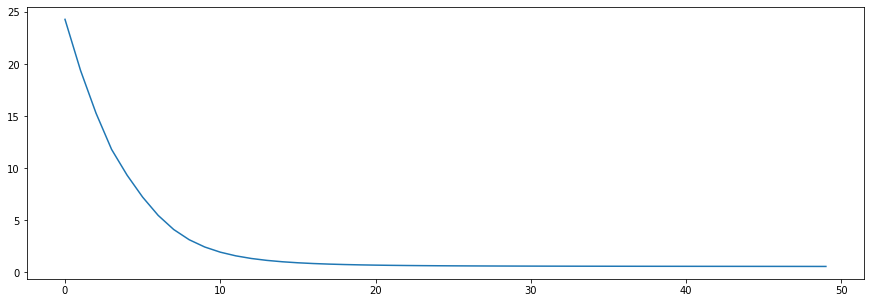

In [7]:
plt.plot(np.arange(model.num_ep),loss_hist.cpu().detach().numpy())

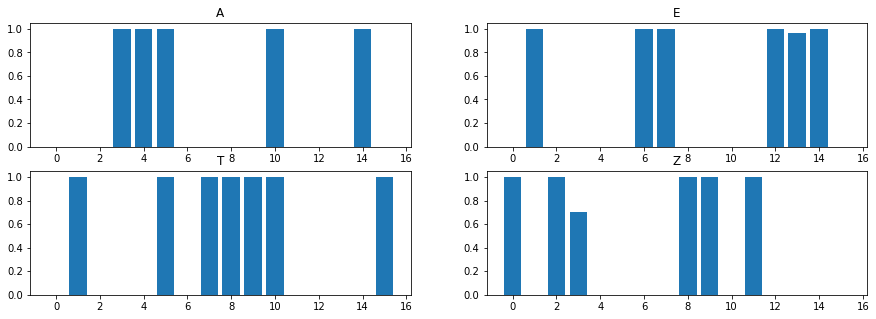

In [8]:
idx = [0,4,9,-1]

fig, axs = plt.subplots(2,2)
axs = axs.ravel()
label = ['A','E','T','Z']

for i,ax in enumerate(axs):
    Z,H,O = model.forw_conv(x_train[idx[i]])
    
    ax.bar(np.arange(model.dims[1]),H.cpu().detach().numpy())
    ax.set_title(label[i])

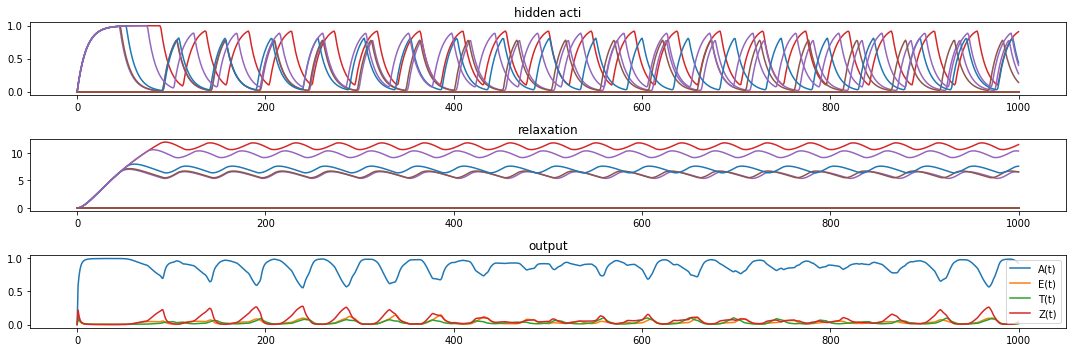

In [9]:
dyn_params = [0.01,0.1,2,0.05,0,0]   # [tau_h, tau_r, r_scale factor, T, h start, R start]
timevec = np.linspace(0,1,1000)
alpha_params = [0,0]

H_t, R_t, O_t, Z_t = model.forw_dyn(x_train[0], dyn_params, timevec, alpha_params)

fig,ax = plt.subplots(3,1)
ax[2].plot(O_t.T.cpu().detach().numpy())
ax[2].legend(('A(t)','E(t)','T(t)','Z(t)'),loc='lower right')
ax[2].set_title('output')

ax[1].plot(R_t.T.cpu().detach().numpy())
ax[1].set_title('relaxation')
ax[0].plot(H_t.T.cpu().detach().numpy())
ax[0].set_title('hidden acti')
fig.tight_layout()



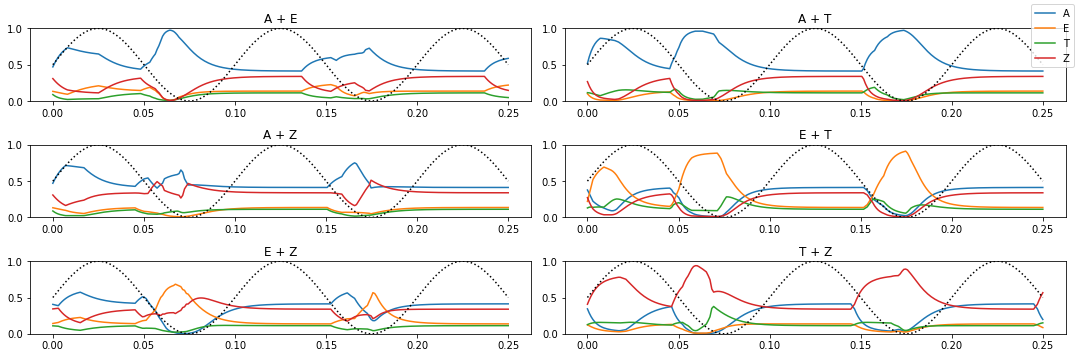

In [10]:
# competing inputs 
alpha_params = [10,5]
dyn_params = [0.01,0.1,4,0.01,0,0]   # [tau_h, tau_r, r_scale factor, T, h start, R start]

label = ['A','E','T','Z']
idx = np.array((0,5,9,13))

label_idx = np.arange(4)
inp_combi = list(combinations(idx,2))           # possible combinations

timevec = np.linspace(0,0.25,250)
fig,ax = plt.subplots(3,2)
ax = ax.ravel()
plt.setp(ax,yticks=np.arange(0,1.5,0.5))
for i,comp_inp in enumerate(inp_combi):
    input_ = x_train[comp_inp[0]] *1.1+ x_train[comp_inp[1]]*0.9
    _,_,O_t,_ = model.forw_dyn(input_, dyn_params, timevec, alpha_params)
    
    ax[i].plot(timevec,O_t[:,1:].T.cpu().detach().numpy())
    ax[i].plot(timevec,np.sin(2*np.pi*timevec*alpha_params[0])*0.5+0.5,'k',linestyle=':')
    ax[i].set_ylim((0,1))
    fi = [np.where(idx == comp_inp[0])[0][0], np.where(idx == comp_inp[1])[0][0]]
    ax[i].set_title(label[fi[0]] + ' + ' + label[fi[1]])
fig.legend((label))
fig.tight_layout()